In [1]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import time

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# File paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
FIG_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/results/fig_hep'
DS_LIST = ['aizarani']

# Score files
DIC_SCORE_PATH = {'aizarani': DATA_PATH+'/score_file/score.liver_atlas.magma_10kb_1000'
                 }

DIC_TRAIT_LIST = {}
DIC_TRAIT_LIST = {'aizarani': ['UKB_460K.biochemistry_LDLdirect']}

In [3]:
# Load raw data 
dic_data_raw = {}
dic_data_raw['aizarani'] = dl.load_aizarani_raw_data(opt='raw')

dic_data_proc = {}
dic_data_proc['aizarani'] = dl.load_aizarani_raw_data(opt='processed')

In [4]:
# Load score 
dic_score = {x:pd.DataFrame() for x in DIC_SCORE_PATH}
for score in DIC_SCORE_PATH:
    for trait in DIC_TRAIT_LIST[score]:
        file_path = join(DIC_SCORE_PATH[score], '%s.score.gz'%trait)
        if os.path.exists(file_path):
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
            temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
            dic_score[score] = pd.concat([dic_score[score], temp_df], axis=1)
        else:
            print('# missing: %s'%file_path)   

### Get data for only hepatocytes and rerun harmony+umap

In [5]:
temp_df = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/liver_atlas/'
                      'Aizarani_Nature_2019_liver_supp_table3.txt', sep='\t', index_col=1)
hep_list = temp_df.columns[1:]

Trying to set attribute `.obs` of view, copying.


aizarani


2021-05-27 18:00:25,218 - harmonypy - INFO - Iteration 1 of 20
2021-05-27 18:00:25,842 - harmonypy - INFO - Iteration 2 of 20
2021-05-27 18:00:26,397 - harmonypy - INFO - Iteration 3 of 20
2021-05-27 18:00:26,766 - harmonypy - INFO - Iteration 4 of 20
2021-05-27 18:00:27,251 - harmonypy - INFO - Iteration 5 of 20
2021-05-27 18:00:27,737 - harmonypy - INFO - Iteration 6 of 20
2021-05-27 18:00:28,033 - harmonypy - INFO - Iteration 7 of 20
2021-05-27 18:00:28,283 - harmonypy - INFO - Iteration 8 of 20
2021-05-27 18:00:28,533 - harmonypy - INFO - Iteration 9 of 20
2021-05-27 18:00:28,783 - harmonypy - INFO - Iteration 10 of 20
2021-05-27 18:00:29,103 - harmonypy - INFO - Iteration 11 of 20
2021-05-27 18:00:29,329 - harmonypy - INFO - Iteration 12 of 20
2021-05-27 18:00:29,602 - harmonypy - INFO - Iteration 13 of 20
2021-05-27 18:00:29,828 - harmonypy - INFO - Iteration 14 of 20
2021-05-27 18:00:30,078 - harmonypy - INFO - Iteration 15 of 20
2021-05-27 18:00:30,304 - harmonypy - INFO - Iter

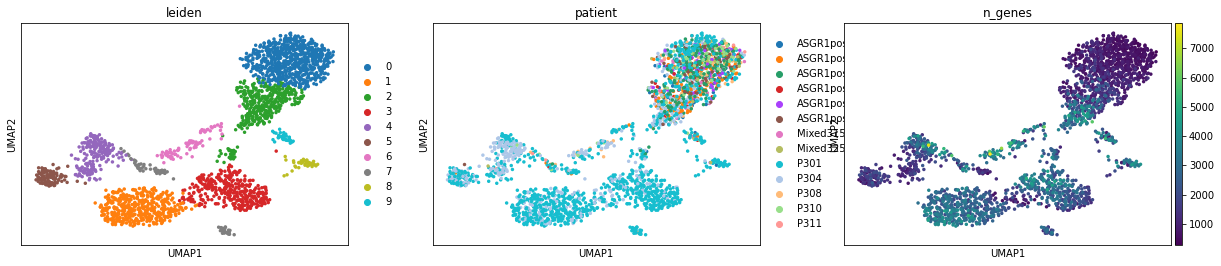

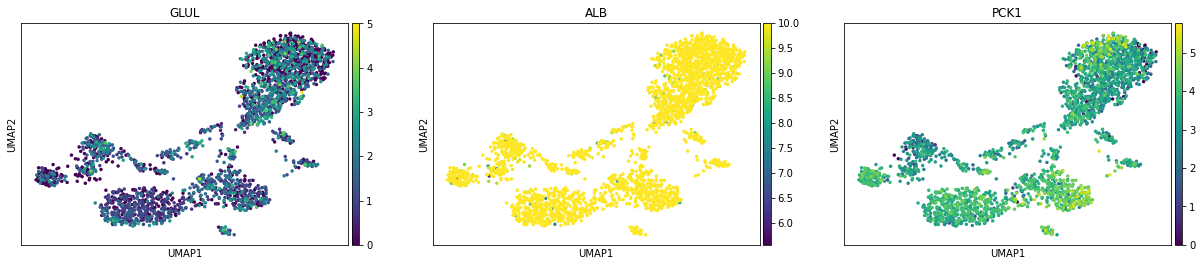

In [61]:
# Reprocess hep data
dic_data_proc = {}
temp_dic = {'ASGR1pos304':'P304', 'ASGR1pos308':'P308', 'ASGR1pos310':'P310', 'ASGR1pos315':'P315', 
            'ASGR1pos325':'P325', 'Mixed315':'P315', 'Mixed325':'P325'}
for ds in DS_LIST:
    print(ds)
    adata = dic_data_raw[ds][hep_list,:].copy()
    adata.obs['zonation'] = np.arange(adata.shape[0])
    sc.pp.filter_cells(adata, min_genes=250)
    sc.pp.filter_genes(adata, min_cells=50)
    
    # Get patient info
    adata.obs['patient'] = [x.split('_')[0] for x in adata.obs_names]
#     adata.obs['patient'] = [temp_dic[x] if x in temp_dic else x for x in adata.obs['patient']]
    temp_df = adata.obs.groupby('patient').agg({'cell_id':len})
    patient_list = list(temp_df.index[temp_df['cell_id']>10])
    adata = adata[adata.obs['patient'].isin(patient_list)]
    adata.obs['batch_harmony'] = adata.obs['patient']
    adata.obs['batch_harmony'] = adata.obs['batch_harmony'].astype('category')

    sc.pp.highly_variable_genes(adata, subset = False, min_disp=.5, 
                                min_mean=.0125, max_mean=10, n_bins=20, n_top_genes=None)
    sc.pp.scale(adata, max_value=10, zero_center=False)
    sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
    sc.external.pp.harmony_integrate(adata, key='batch_harmony', max_iter_harmony=20)
    sc.pp.neighbors(adata, n_neighbors=50, n_pcs=20, use_rep="X_pca_harmony")
#     sc.pp.neighbors(adata, n_neighbors=50, n_pcs=20, use_rep="X_pca")
    sc.tl.leiden(adata, resolution=0.7)   
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=['leiden', 'patient', 'n_genes'])
    sc.pl.umap(adata, color=['GLUL', 'ALB', 'PCK1'])
    adata.write('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/tms_proc/'
                'hep.%s.h5ad'%ds)
    break

In [39]:
for cell in list(adata.obs_names[adata.obs['patient']=='P301']):
    print(cell)

P301_8_130
P301_8_127
P301_5_28
P301_4_98
P301_17_5
P301_10_123
P301_4_103
P301_8_131
P301_8_154
P301_4_172
P301_9_92
P301_3_44
P301_8_102
P301_28_117
P301_6_162
P301_30_184
P301_23_79
P301_29_66
P301_10_98
P301_32_171
P301_31_38
P301_30_185
P301_30_114
P301_32_174
P301_3_79
P301_30_171
P301_23_77
P301_29_90
P301_32_159
P301_17_53
P301_29_2
P301_24_138
P301_30_170
P301_29_23
P301_29_63
P301_23_44
P301_4_139
P301_29_44
P301_17_37
P301_27_40
P301_3_70
P301_29_73
P301_30_143
P301_32_106
P301_23_68
P301_32_150
P301_17_21
P301_30_169
P301_29_75
P301_29_67
P301_7_11
P301_23_19
P301_7_12
P301_29_79
P301_17_54
P301_29_52
P301_31_20
P301_9_78
P301_9_7
P301_24_133
P301_32_175
P301_3_38
P301_29_70
P301_9_9
P301_31_27
P301_31_61
P301_32_160
P301_32_188
P301_9_38
P301_23_46
P301_30_126
P301_17_90
P301_9_5
P301_10_104
P301_9_12
P301_32_110
P301_23_62
P301_29_27
P301_31_23
P301_31_37
P301_9_17
P301_32_103
P301_4_189
P301_23_67
P301_32_154
P301_9_33
P301_7_29
P301_3_60
P301_32_124
P301_24_102
P301_32_

In [31]:
'P301_8_130' in dic_data_raw['aizarani'].obs.index

True

In [34]:
np.sum(['P301' in x for x in dic_data_raw['aizarani'].obs.index])

1704

In [44]:
[x for x in dic_data_raw['aizarani'].obs.index if 'P304' in x]

['P304_1_2',
 'P304_1_4',
 'P304_1_5',
 'P304_1_7',
 'P304_1_8',
 'P304_1_9',
 'P304_1_12',
 'P304_1_13',
 'P304_1_14',
 'P304_1_15',
 'P304_1_16',
 'P304_1_17',
 'P304_1_19',
 'P304_1_20',
 'P304_1_22',
 'P304_1_27',
 'P304_1_28',
 'P304_1_33',
 'P304_1_34',
 'P304_1_36',
 'P304_1_37',
 'P304_1_38',
 'P304_1_41',
 'P304_1_42',
 'P304_1_43',
 'P304_1_45',
 'P304_1_47',
 'P304_1_48',
 'P304_1_51',
 'P304_1_52',
 'P304_1_54',
 'P304_1_56',
 'P304_1_57',
 'P304_1_58',
 'P304_1_60',
 'P304_1_64',
 'P304_1_66',
 'P304_1_67',
 'P304_1_68',
 'P304_1_69',
 'P304_1_71',
 'P304_1_73',
 'P304_1_74',
 'P304_1_75',
 'P304_1_76',
 'P304_1_77',
 'P304_1_79',
 'P304_1_80',
 'P304_1_83',
 'P304_1_86',
 'P304_1_87',
 'P304_1_88',
 'P304_1_90',
 'P304_1_92',
 'P304_10_14',
 'P304_10_19',
 'P304_10_25',
 'P304_10_31',
 'P304_10_36',
 'P304_10_45',
 'P304_10_48',
 'P304_10_52',
 'P304_10_60',
 'P304_10_62',
 'P304_10_67',
 'P304_10_75',
 'P304_10_91',
 'P304_11_100',
 'P304_11_108',
 'P304_11_110',
 'P304_

In [54]:
temp_df = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/liver_atlas/'
                      'GSM3531672_P301_3_CRYOMIXED11.coutt.csv.gz', sep='\t')

In [55]:
temp_df

,GENEID,1,2,3,4,5,6,7,8,9,...,183,184,185,186,187,188,189,190,191,192
0,7SK__chr11,0.000000,1.000122,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A1BG__chr19,1.000122,13.020674,1.000122,8.007823,9.009902,13.020674,7.005988,0.000000,4.001954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A1CF__chr10,0.000000,9.009902,0.000000,4.001954,4.001954,8.007823,1.000122,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A2M__chr12,0.000000,2.000488,0.000000,3.001099,1.000122,4.001954,1.000122,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A4GALT__chr22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13800,bP-21201H5.2__chr21,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13801,bP-21264C1.2__chr21,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13802,snoU13__chr15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000122,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13803,snoU2-30__chrX,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
adata.obs['patients'] = [x.split('_')[0] for x in adata.obs.index]

In [48]:
adata.obs.groupby('patients').agg({'cell_id':len})

,cell_id
patients,
ASGR1,3
ASGR1pos,2
ASGR1pos304,67
ASGR1pos308,209
ASGR1pos310,209
ASGR1pos315,36
ASGR1pos325,68
ASGR1posCD45neg,82
ASGR1posCD45pos,27
